In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.regularizers import l2
import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
df = pd.read_csv('01-01-2000-01-07-2018-hourly-readings-2.csv')

# Visualizando o dataset

In [4]:
df.head(10)

,index,#,W Dir,W Spd m/s,STD W Dir,Temp 2m,Temp 8m,Glob Rad W/m2,Rel Hum %
0,0,01/01/2000 01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,01/01/2000 02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,01/01/2000 03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,01/01/2000 04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,01/01/2000 05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,01/01/2000 06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,01/01/2000 07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,01/01/2000 08:00,245.3,1.797,11.09,2.49,3.697,NaN,89.2998
8,8,01/01/2000 09:00,271.6,2.083,9.89,2.86,3.141,17.85,88.7000
9,9,01/01/2000 10:00,266.6,1.694,12.89,3.31,3.503,89.20,88.1000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166559 entries, 0 to 166558
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          166559 non-null  int64  
 1   #              166559 non-null  object 
 2   W Dir          160874 non-null  float64
 3   W Spd m/s      160863 non-null  float64
 4   STD W Dir      160818 non-null  float64
 5   Temp 2m        147643 non-null  float64
 6   Temp 8m        157683 non-null  float64
 7   Glob Rad W/m2  95660 non-null   float64
 8   Rel Hum %      160833 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.4+ MB


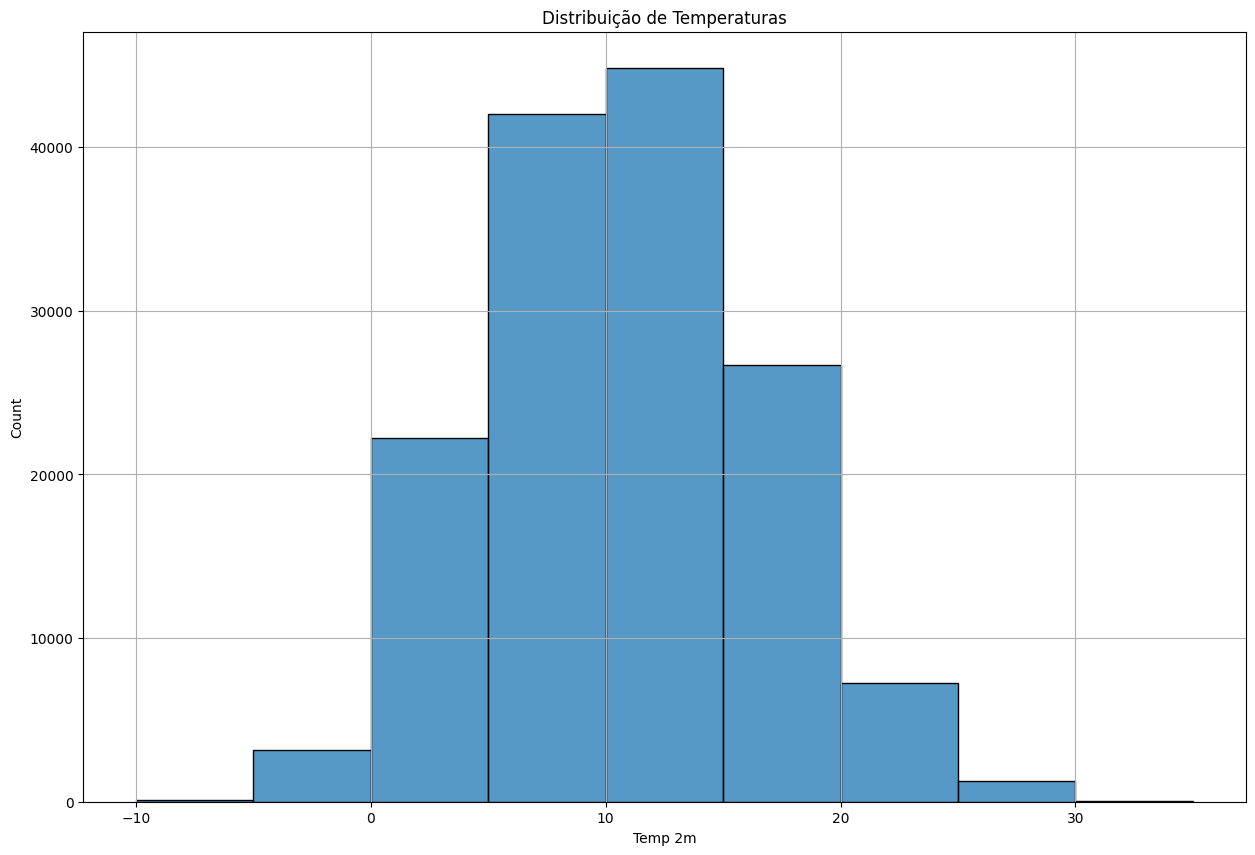

In [6]:
plt.figure(figsize=(15, 10))
sns.histplot(df['Temp 2m'],bins=[i for i in range(-10,40,5)], kde=False)
plt.title("Distribuição de Temperaturas")
plt.grid()
plt.show()

# Limpando os dados

In [7]:
# Renomenado as colunas
df.columns = ['index', 'datetime', 'wind_dir', 'wind_speed', 'std_wind_dir', 'temp_2m', 'temp_8m', 'glob_rad', 'rel_hum']

# Convertendo a coluna datetime para o formato datetime
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M')

# Setando a coluna datetime como index
df.set_index('datetime', inplace=True)

# Removendo a coluna index
df.drop(columns=['index'], inplace=True)

# Passando as colunas de ângulo para seno e cosseno
df['sin_wind_dir'] = np.sin(np.radians(df['wind_dir']))
df['cos_wind_dir'] = np.cos(np.radians(df['wind_dir']))

df['sin_std_wind_dir'] = np.sin(np.radians(df['std_wind_dir']))
df['cos_std_wind_dir'] = np.cos(np.radians(df['std_wind_dir']))

# Removendo as colunas de ângulo
df.drop('wind_dir', axis=1, inplace=True)
df.drop('std_wind_dir', axis=1, inplace=True)

df.head()

,wind_speed,temp_2m,temp_8m,glob_rad,rel_hum,sin_wind_dir,cos_wind_dir,sin_std_wind_dir,cos_std_wind_dir
datetime,,,,,,,,,
2000-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Verificando valores nulos
df.isna().sum()

wind_speed           5696
temp_2m             18916
temp_8m              8876
glob_rad            70899
rel_hum              5726
sin_wind_dir         5685
cos_wind_dir         5685
sin_std_wind_dir     5741
cos_std_wind_dir     5741
dtype: int64

In [9]:
# Preenchendo valores nulos
df = df.fillna(method='ffill')

C:\Users\jpthe\AppData\Local\Temp\ipykernel_27192\388020171.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [10]:
# Notamos algumas inconsistências nos dados antes de 2001 e a partir de 2011, então vamos remover esses dados
df = df.loc['2001':'2010']

df.head(-1)

,wind_speed,temp_2m,temp_8m,glob_rad,rel_hum,sin_wind_dir,cos_wind_dir,sin_std_wind_dir,cos_std_wind_dir
datetime,,,,,,,,,
2001-01-01 00:00:00,3.90000,2.35000,2.47800,0.162,92.2998,0.563526,-0.826098,0.343496,0.939154
2001-01-01 01:00:00,1.81500,2.35000,2.87300,0.338,92.1000,0.859852,-0.510543,0.657244,0.753678
2001-01-01 02:00:00,1.76800,2.35000,3.44100,0.143,91.2000,0.909961,-0.414693,0.716423,0.697667
2001-01-01 03:00:00,3.76300,2.35000,3.34000,0.646,92.2000,0.999560,0.029670,0.231748,0.972776
2001-01-01 04:00:00,1.59800,2.35000,3.56000,0.341,92.7998,0.957319,0.289032,0.304033,0.952661
...,...,...,...,...,...,...,...,...,...
2010-12-31 18:00:00,4.75018,4.52150,7.23000,0.563,82.6000,-0.997789,-0.066465,0.274295,0.961646
2010-12-31 19:00:00,4.75362,4.54543,7.35000,0.563,81.6000,-0.999917,0.012898,0.239720,0.970842
2010-12-31 20:00:00,4.75705,4.56934,7.35999,0.563,81.7000,-0.995707,0.092562,0.257470,0.966286


In [11]:
# Conferindo se ainda existem valores nulos
df.isna().sum()

wind_speed          0
temp_2m             0
temp_8m             0
glob_rad            0
rel_hum             0
sin_wind_dir        0
cos_wind_dir        0
sin_std_wind_dir    0
cos_std_wind_dir    0
dtype: int64

In [12]:
df.head()

,wind_speed,temp_2m,temp_8m,glob_rad,rel_hum,sin_wind_dir,cos_wind_dir,sin_std_wind_dir,cos_std_wind_dir
datetime,,,,,,,,,
2001-01-01 00:00:00,3.900,2.35,2.478,0.162,92.2998,0.563526,-0.826098,0.343496,0.939154
2001-01-01 01:00:00,1.815,2.35,2.873,0.338,92.1000,0.859852,-0.510543,0.657244,0.753678
2001-01-01 02:00:00,1.768,2.35,3.441,0.143,91.2000,0.909961,-0.414693,0.716423,0.697667
2001-01-01 03:00:00,3.763,2.35,3.340,0.646,92.2000,0.999560,0.029670,0.231748,0.972776
2001-01-01 04:00:00,1.598,2.35,3.560,0.341,92.7998,0.957319,0.289032,0.304033,0.952661


# Preprocessamento dos dados e separação em train e test

In [13]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Define the sequence length and forecast horizon
n_steps = 240
forecast = 24

# Creating data sequences
def create_sequence(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix + forecast > len(data):
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix:end_ix + forecast, 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X, y = create_sequence(scaled_data, n_steps)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (69908, 240, 9)
X_test shape: (17477, 240, 9)
y_train shape: (69908, 24)
y_test shape: (17477, 24)


In [14]:
# For faster training, let's use a smaller subset of the data
#X_train = X_train[:1000]
#y_train = y_train[:1000]
#X_test = X_test[:200]
#y_test = y_test[:2000]


# Treinamento do modelo

In [15]:
# Function to build the model, taking hyperparameters as arguments
def build_model(hp):
    model = Sequential()

    # Add LSTM layers with varying units and L2 regularization
    for i in range(hp.Int('num_layers', 1, 2)):
        model.add(LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
                       return_sequences=(i < hp.Int('num_layers', 1, 2) - 1),
                       input_shape=(X_train.shape[1], X_train.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(hp.Float(f'l2_{i}', min_value=1e-5, max_value=1e-3, sampling='LOG'))))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.3, step=0.1)))

    # Add a dense layer with one output unit
    model.add(Dense(24, kernel_regularizer=l2(hp.Float('l2_dense', min_value=1e-5, max_value=1e-3, sampling='LOG'))))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning')

# Use a smaller subset of the data for tuning
sample_indices = np.random.choice(len(X_train), size=int(0.1 * len(X_train)), replace=False)
sample_train_x = X_train[sample_indices]
sample_train_y = y_train[sample_indices]

# Perform the hyperparameter search
tuner.search(sample_train_x, sample_train_y, epochs=5, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
Optimal number of layers: {best_hps.get('num_layers')}
Optimal units per layer: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}
Optimal L2 regularization per layer: {[best_hps.get(f'l2_{i}') for i in range(best_hps.get('num_layers'))]}
Optimal dropout per layer: {[best_hps.get(f'dropout_{i}') for i in range(best_hps.get('num_layers'))]}
Optimal L2 regularization for dense layer: {best_hps.get('l2_dense')}
""")

Trial 10 Complete [00h 01m 32s]
val_loss: 0.005829253699630499

Best val_loss So Far: 0.00493672164157033
Total elapsed time: 00h 58m 23s

The hyperparameter search is complete. 
Optimal number of layers: 1
Optimal units per layer: [64]
Optimal L2 regularization per layer: [0.0004017288763918231]
Optimal dropout per layer: [0.1]
Optimal L2 regularization for dense layer: 1.1192004017268887e-05



In [16]:
# Criando o modelo LSTM para prever a temperatura das próximas 24 horas
model = tuner.hypermodel.build(best_hps)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,504 (80.09 KB)

 Trainable params: 20,504 (80.09 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Definindo callbacks para early stopping e model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_weights.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Treinando o modelo
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - loss: 0.0290 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 2/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - loss: 0.0055 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 3/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - loss: 0.0045 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 4/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - loss: 0.0041 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 5/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - loss: 0.0039 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 6/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - loss: 0.0037 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 7/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - loss: 0.0036 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 8/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - loss: 0.0035 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 9/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - loss: 0.0035 - val_loss: 0.0032 - learning_rate:

In [18]:
# Carregando o melhor modelo salvo durante o treinamento
best_model = tf.keras.models.load_model('best_model_weights.keras')
test_loss = best_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0043
Test Loss: 0.0036551353987306356


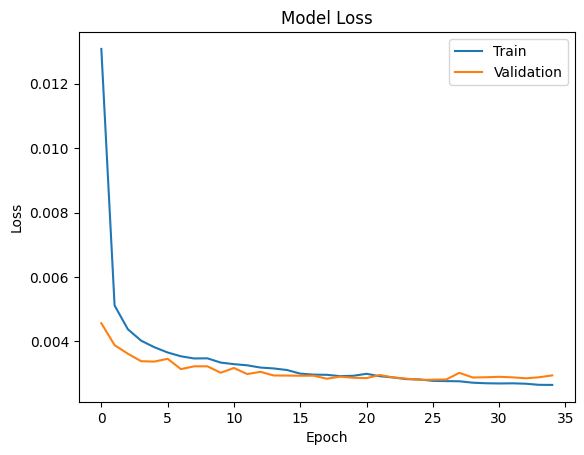

In [19]:
# Plotando a loss do modelo durante o treinamento e validação
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Avaliando desempenho do melhor modelo

In [20]:

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fazendo previsões com o modelo
predictions = best_model.predict(X_test)

# Calculando métricas de erro
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Métricas com o treino
train_predictions = best_model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)

print("Train Mean Absolute Error (MAE):", train_mae)
print("Train Mean Squared Error (MSE):", train_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)

547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step
Mean Absolute Error (MAE): 0.04142635413730637
Mean Squared Error (MSE): 0.0034717647864856613
Root Mean Squared Error (RMSE): 0.058921683500097494
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step
Train Mean Absolute Error (MAE): 0.038134318082356844
Train Mean Squared Error (MSE): 0.002520709083651583
Train Root Mean Squared Error (RMSE): 0.05020666373751181


# Fazendo a previsão

In [21]:
def inverse_transform_temperature(scaled_values, scaler, feature_index=1):
    # Create a template of zeros with the same shape as scaled_data
    template = np.zeros((scaled_values.shape[0], scaled_data.shape[1]))
    # Place the scaled values into the temperature feature position
    template[:, feature_index] = scaled_values
    # Inverse transform the whole array
    inversed = scaler.inverse_transform(template)
    # Return only the temperature column
    return inversed[:, feature_index]

In [22]:
def plot_predictions_with_history(input_data, actual, forecast, scaler, title="Temperature Prediction"):
    plt.figure(figsize=(10, 6))
    
    # Inverse transform the past temperatures (input_data)
    input_temp = inverse_transform_temperature(input_data[:, 1], scaler)
    
    # Inverse transform the actual future temperatures
    actual_temp = inverse_transform_temperature(actual, scaler)
    
    # Inverse transform the forecasted temperatures
    forecast_temp = inverse_transform_temperature(forecast, scaler)
    
    # Plot the actual past values (temperature feature)
    plt.plot(range(len(input_temp)), input_temp, label='Actual Past', marker='o', linestyle='-')
    # Plot the forecasted values
    plt.plot(range(len(input_temp), len(input_temp) + len(forecast_temp)), forecast_temp, label='Forecast', marker='x', linestyle='--')
    # Plot the actual future values for comparison
    plt.plot(range(len(input_temp), len(input_temp) + len(actual_temp)), actual_temp, label='Actual Future', marker='o', linestyle='-')
    
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.title(title)
    plt.show()


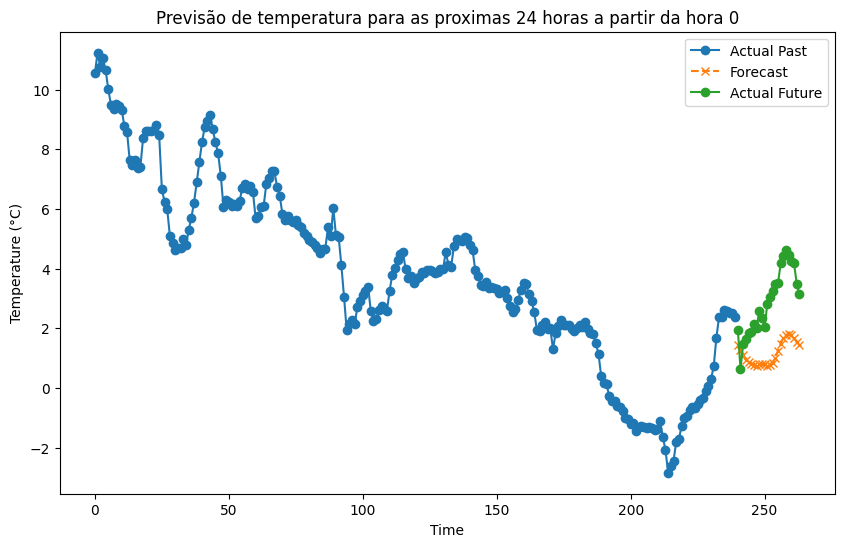

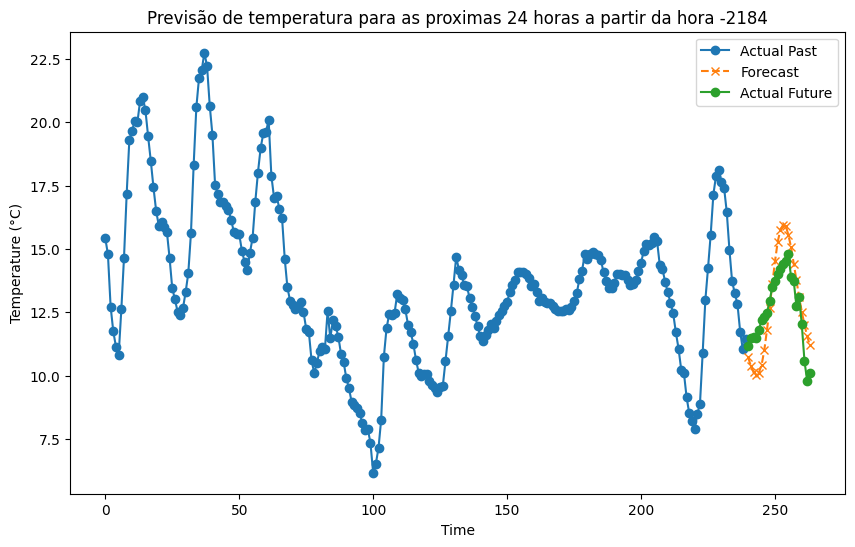

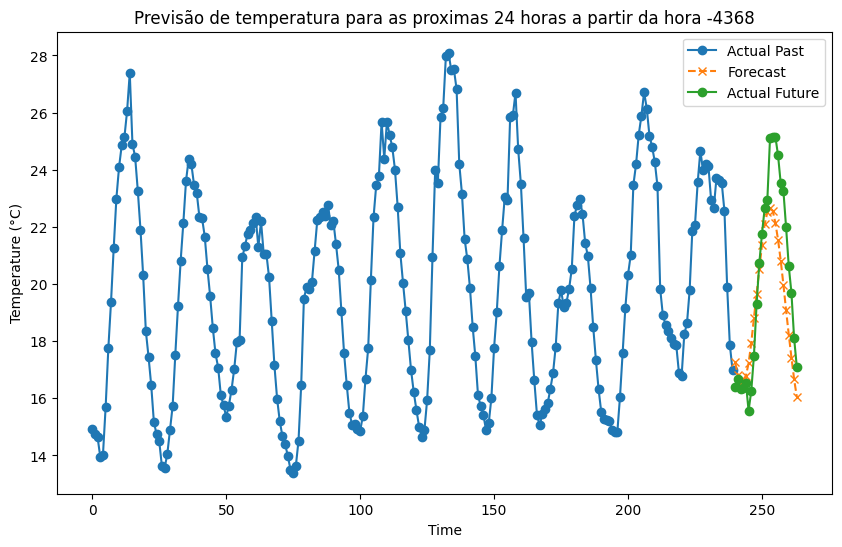

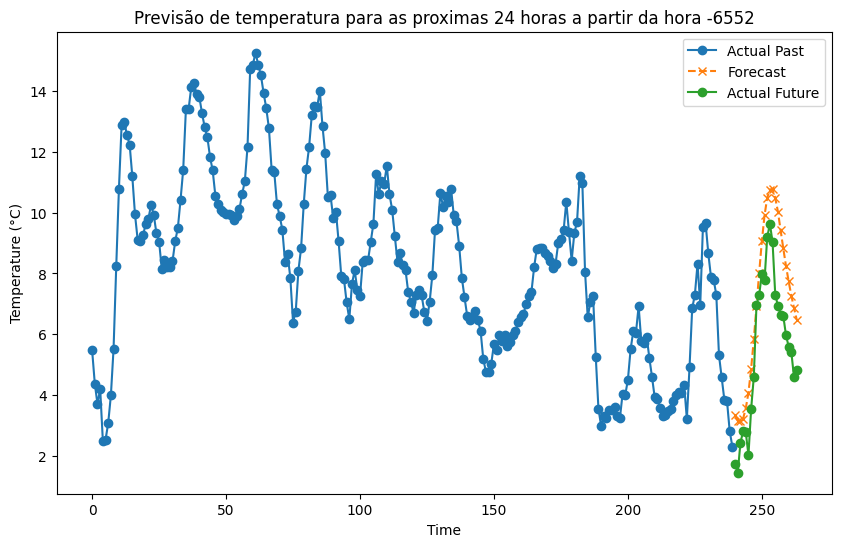

In [28]:
hora_inicial = 0
increment = 91*24

num_loops = 4


for i in range(num_loops):
    hora = hora_inicial + i * increment
    plot_predictions_with_history(X_test[-hora], y_test[-hora], predictions[-hora], scaler, title=f"Previsão de temperatura para as proximas 24 horas a partir da hora {-hora}")